In [1]:
#Team Members:
#Sean Fitzgibbon - 19273444
#Daniel Larkin - 19257503
#Adam Butler - 19244967

#This code executes to end without error.

#We opted to re-use parts of existing implementations from various sources. We changed these to suit our dataset and various hyperparameters, network structure and more.
#https://www.tensorflow.org/tutorials/load_data/images
#https://www.kaggle.com/code/sushovansaha9/pistachio-xception-keras

In [2]:
#install prerequisites
!pip install imutils
!pip install wget
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=5c6462721d43fe1e4de035b4d1953e9ca1f699d8f8cc508840975f034a808fcf
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
#import libraries
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Dropout,Convolution2D,MaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import splitfolders
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os
import wget
import cv2
import tensorflow as tf
import tensorflow_datasets.public_api as tfds

In [4]:
#Split dataset into training, validation and test sets

#Splits data using tensorflowdataset.load function
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'], #80% of original dataset for training, 10% for validation, final 10% for testing
    with_info=True, #keep info (labels)
    as_supervised=True, #assigns values to each input tuples i.e. (input, label)
)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to ~/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [5]:
#Loader params
batch_size = 32
img_height = 180
img_width = 180

In [6]:
#Normalizing data

#This layer applies to each input of any data set (train, val and test)
#It applies a rescaling and resizing function to normalize the RGB values and image dimensions
normalization_layer = tf.keras.Sequential([ 
    layers.Rescaling(1./255), #Rescale the image from RGB 0-255 to RGB 0-1
    layers.Resizing(img_width, img_height), #Resize the image to specified image width and image height
])

#This layer applies to only the training dataset below. 
#It applies a random flip, random rotate and random zoom operation using tensorflow functions.
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"), #Flip image horizontally or vertically
    layers.RandomRotation(0.2), #Rotate image by specified multiplier
    layers.RandomZoom(0.3), #Zoom image by specified multiplier
])

In [7]:
#This block is a prepare function allowing us to resize + rescale all datasets
#It also checks and applies augmentation to only the training data

AUTOTUNE = tf.data.AUTOTUNE #Determines CPU budget to use

def prepare(ds, shuffle=False, augment=False): #Inputs are dataset, not shuffling data, and augment var
  #Resize and rescale all datasets.
  ds = ds.map(lambda x, y: (normalization_layer(x), y), #Apply our normalization layer to the datasets, 
              num_parallel_calls=AUTOTUNE)              #setting parallel call num to the AUTOTUNE var specified above
  
  #If shuffle is true, shuffle dataset
  if shuffle:
    ds = ds.shuffle(1000)

  #Batch all datasets using batch_size var specified in block 5
  ds = ds.batch(batch_size)

  #Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), #Apply data_aug layer to the dataset,
                num_parallel_calls=AUTOTUNE)                           #setting parallel call num to the AUTOTUNE var specified above

  #Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

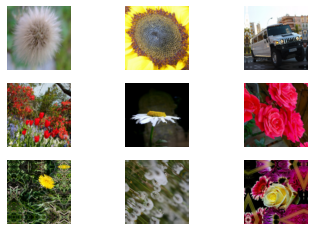

In [8]:
#Now we call the prepare function defined above
train_ds = prepare(train_ds, shuffle=True, augment=True) #Assign shuffle=true and augment=true since we are working with train dataset
val_ds = prepare(val_ds) #Leave default values for validation dataset (i.e. dont apply augmentation)
test_ds = prepare(test_ds) #Leave default values for test dataset (i.e. dont apply augmentation)

#Loop to display some augmented images using pyplot
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy())
    #plt.title(class_names[labels[i]])
    plt.axis("off")

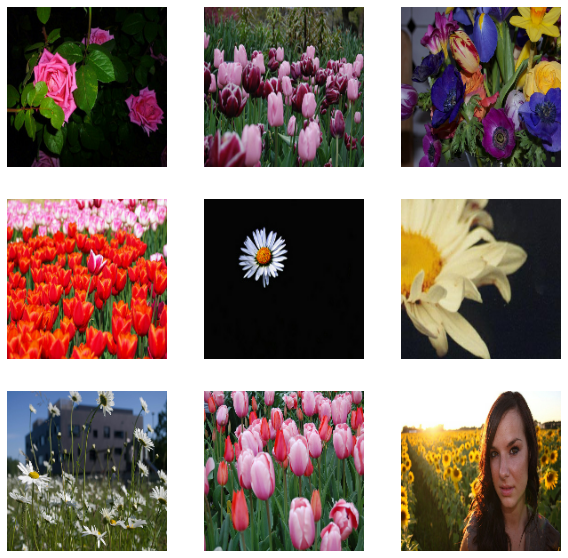

In [9]:
#Loop to display normal sample images from validation dataset using pyplot
plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy())
    #plt.title(label)
    plt.axis("off")

In [10]:
#Here we create our network using the Xception base model

#Assign Xception architecture to baseModel
baseModel = Xception(
    weights="imagenet", #imagenet weights as we are working with images
    include_top=False, #omit the top layer from Xception architecture
    input_tensor=Input(shape=(img_width, img_height, 3)) #set input type to match input dimensions and channels
    )

headModel = baseModel.output #set headModel as output of above block

headModel = AveragePooling2D(pool_size=(5, 5))(headModel) #pooling layer of size 5x5, cast to headModel
headModel = Flatten(name="flatten")(headModel) #flatten layer, cast to headModel

headModel = Dense(128, activation="relu")(headModel) #Dense layer with rectified linear unit activation, cast to headModel
#headModel = BatchNormalization()(headModel)
headModel = Dropout(0.2)(headModel) #Dropout layer with parameter 0.4, we found results to be satisfactory with this figure

headModel = Dense(5, activation="softmax")(headModel) #Another Dense layer with softmax activation for output, cast to headModel
#headModel = BatchNormalization()(headModel) #Batch Normalization layer
model = Model(inputs=baseModel.input, outputs=headModel) #set model inputs and outputs to match baseModel and headModel

#Make baseModel layers un-trainable
for layer in baseModel.layers:
  layer.trainable = False



#Compile the model, with loss function of sparse categorical cross entropy type, using Adam optimizer, and accuracy as our metric.
#We also tried using SGD (Stochastic Gradient Descent) as our optimizer, but found that results were not as accurate and suffered more of a loss.
#We also triend using MSE (Mean Squared Error) as our loss function, but found results were not satisfactory
model.compile(loss="sparse_categorical_crossentropy", optimizer = 'Adam', metrics=["accuracy"])
print("Model Compiled")

83683744/83683744 [==============================] - 3s 0us/step
Model Compiled


In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 89, 89, 32)   864         ['input_1[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 89, 89, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                              

In [12]:
#Here we begin to run the network using our datasets defined and augmented (if train) datasets
#We set epochs to various values, and decided to stick with 20 for a healthy result.

epochs=20 #Set epochs (iterations)

#Fit the datasets to the model (network) and run. History will be recorded and accessed using the 'H' variable
H = model.fit(
    train_ds, #Training dataset
    validation_data = val_ds, #Validation dataset
    epochs=epochs #Set epochs value to epochs var above
    )

Epoch 1/20
92/92 [==============================] - 36s 256ms/step - loss: 0.7723 - accuracy: 0.7054 - val_loss: 0.4466 - val_accuracy: 0.8474
Epoch 2/20
92/92 [==============================] - 22s 235ms/step - loss: 0.5462 - accuracy: 0.7919 - val_loss: 0.4098 - val_accuracy: 0.8447
Epoch 3/20
92/92 [==============================] - 22s 231ms/step - loss: 0.4936 - accuracy: 0.8239 - val_loss: 0.3615 - val_accuracy: 0.8610
Epoch 4/20
92/92 [==============================] - 22s 232ms/step - loss: 0.4683 - accuracy: 0.8215 - val_loss: 0.4005 - val_accuracy: 0.8338
Epoch 5/20
92/92 [==============================] - 23s 237ms/step - loss: 0.4087 - accuracy: 0.8389 - val_loss: 0.3000 - val_accuracy: 0.8883
Epoch 6/20
92/92 [==============================] - 23s 241ms/step - loss: 0.3918 - accuracy: 0.8512 - val_loss: 0.3036 - val_accuracy: 0.8910
Epoch 7/20
92/92 [==============================] - 23s 237ms/step - loss: 0.3785 - accuracy: 0.8542 - val_loss: 0.3017 - val_accuracy: 0.8910

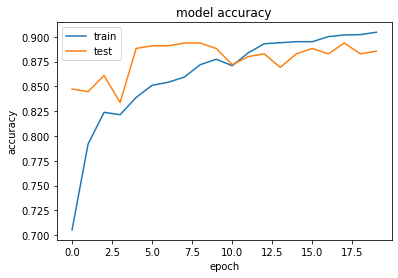

In [13]:
#Now we plot the History of accuracy
#Access history using H.history and specify data

plt.plot(H.history['accuracy']) #Plot Train Accuracy
plt.plot(H.history['val_accuracy']) #Plot Validation Accuracy
plt.title('model accuracy') #Set title
plt.ylabel('accuracy') #Y label
plt.xlabel('epoch') #X label
plt.legend(['train', 'test'], loc='upper left') #Legend of plot displayed in top left
plt.show() #Show our plot

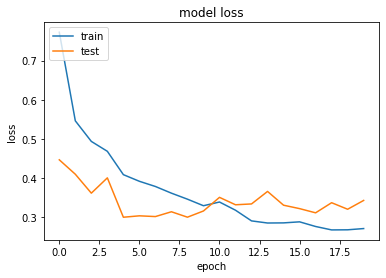

In [14]:
#Now we plot the History of loss
#Access history using H.history and specify data

plt.plot(H.history['loss']) #Plot Train Loss
plt.plot(H.history['val_loss']) #Plot Validation Loss
plt.title('model loss') #Set title
plt.ylabel('loss') #Y label
plt.xlabel('epoch') #X label
plt.legend(['train', 'test'], loc='upper left') #Legend of the plot displayed in top left
plt.show() #Show our plot

In [15]:
#Here we evaluate our model by running the test set we defined at the start of the program
#This will allow us to ensure that our model is running as intended

loss, acc = model.evaluate(test_ds) #Set loss, acc variables using the evaluate function from tensorflow, with our test dataset as the input and our model as the item to be evaluated
print("Accuracy", acc) #Print the accuracy
print("Loss", loss) #Print the loss

12/12 [==============================] - 1s 85ms/step - loss: 0.4276 - accuracy: 0.8583
Accuracy 0.8583106398582458
Loss 0.42757144570350647
